### Find Word Images Padding Picture In Picture

In [1]:
import cv2
import PIL
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import re
import glob
from pathlib import Path
import shutil
from os.path import isfile, join

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
#lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

file_ext = 1000

In [3]:
#word_lemma_all_data_path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
#Lemma Stem POS/Result/3-2-Word In Visual Genome Merge"

visual_genome_process_data_path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Lemma Stem POS/Result/3-0-Visual Genome Process"

path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Lemma Stem POS/Result/3-5-Find Word Images Padding Picture In Picture"

#Path(path).mkdir(parents=True, exist_ok=True)

In [4]:
def image_crop_blur(image_file, x_koor, y_koor, height, width, blur_radius=5, blur_part="outside", border_color="orange", border = (3, 3, 3, 3)):
    '''image_crop_blur(image_file, x_koor, y_koor, height, width, blur_radius=5, crop_part="inside", border_color="orange", border = (3, 3, 3, 3))\n
    image_file is a picture and x_koor, y_koor, height and width are its crop coordinates (x_koor,x_koor+height, y_koor,y_koor+width)\n
    blur_radius is GaussianBlur parameters, high value is more blurring, blur_part used for which part (outside and inside) wanted to blur.\n
    border_color is cropped image border color and border is border thickness.
    ex.\n
    result_list[4] = "\media\ssd\sample\895152896.jpg"\n
    height = 150\n
    width = 120\n
    x_koor = 25\n
    y_koor = 10\n
    image_crop_blur(result_list[4], x_koor=x_koor, y_koor=y_koor, height=height, width=width, blur_radius=7, blur_part="outside")
    '''
    img = Image.open(f"{image_file}")
    cropped_image = img.crop((x_koor, y_koor, x_koor+width, y_koor+height))
    # left, top, right, bottom
    #border = (5, 10, 10, 15)
    cropped_image_border = ImageOps.expand(cropped_image, border=border, fill=border_color)
    if blur_part == "outside":
        blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        blurred_img.paste(cropped_image_border,(x_koor-border[0], y_koor-border[1], x_koor+width+border[2], y_koor+height+border[3]))
        return blurred_img
    elif blur_part == "inside":
        blurred_img = cropped_image_border.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        img.paste(blurred_img,(x_koor-border[0], y_koor-border[1], x_koor+width+border[2], y_koor+height+border[3]))
        return img
    else:
        return img

In [5]:
def image_id_koor_path_crop_blur(df, image_id_column, image_id, image_path, output_path, image_path_addition="*", xheight="height", ywidth="width",
                                xkoor="x_koor", ykoor="y_koor", num_col="num", blur_radius=4, blur_part="outside"):
    '''
    image_id_koor_path_crop_blur(df, image_id_column, image_id, image_path, output_path, image_path_addition="*", xheight="height", ywidth="width",
                                xkoor="x_koor", ykoor="y_koor", num_col="num", blur_radius=4, blur_part="outside")\n
    df is dataframe which includes image_id in image_id_column that represented real image in image_path as image_id name and coordinate columns name like\n
    as xheight="height", ywidth="width", xkoor="x_koor", ykoor="y_koor". Then finding image process with image_crop_blur func using blur_radius=4, blur_part="outside"\n
    and copy to output_path. blur_radius is high that shows more blur and blur_part used for blur "inside" or "outside" of coordinates. image_path_addition="*" used for\n
    glob.glob func.\n
    ex.\n
    image_id_koor_path_crop_blur(df_genome_word_lemma_all_category_concat_dropna_select, "image_id", image_id, image_path, mask_blur_image_path,
                                image_path_addition="*", xheight="height", ywidth="width", xkoor="x_koor", ykoor="y_koor", num_col="num", blur_radius=4, blur_part="outside")
    '''
    df_dropna = df.dropna(subset=[f'{xheight}',f'{ywidth}',f'{xkoor}',f'{ykoor}'])
    df_var_result = df_dropna[df_dropna[f"{image_id_column}"] == image_id]
    for i in range(len(df_var_result)):
        df_var = df_var_result.iloc[[i],]
        num = int(df_var.loc[:,f"{num_col}"])     
        height = int(df_var.loc[:,f"{xheight}"])
        width = int(df_var.loc[:,f"{ywidth}"])
        x_koor = int(df_var.loc[:,f"{xkoor}"])
        y_koor = int(df_var.loc[:,f"{ykoor}"])
        image_path_file_result = glob.glob(f"{image_path}/{image_path_addition}/{image_id}.jpg")[0]
        image_out = image_crop_blur(image_path_file_result, x_koor, y_koor, height, width, blur_radius=blur_radius, blur_part=blur_part)
        image_out.save(f"{output_path}/{image_id}_{num}.jpg")

In [ ]:
def image_padding_aspect_ratio(data_folder_name, data_path, out_folder_name, out_path, padding_color = (0,0,0), aspect_ratio_width = 16, aspect_ratio_height = 9):
       '''
       image_padding_aspect_ratio(data_folder_name, data_path, out_folder_name, out_path, padding_color = (0,0,0), aspect_ratio_width = 16, aspect_ratio_height = 9)\n
       data_folder_name, data_path, out_folder_name, out_path are path and folder in string(str). others are cv2 parameter and image aspesct ratio parameter.\n
       ex.\n
       output_path = f"/home/kurubal/Documents/Modern Ways/Project/{lang_folder.capitalize()}/Image Audio Video/Data/28 Words"\n
       image_path = f"/home/kurubal/Documents/Modern Ways/Project/{lang_folder.capitalize()}/Image Audio Video/Data/28 Words"\n
       image_padding_aspect_ratio("Images_SV_Rename", image_path, "Images_SV", output_path, padding_color = (0,0,0), aspect_ratio_width = 16, aspect_ratio_height = 9)
       '''
       error_file_list = []
       result_path = f"{out_path}/{out_folder_name}"
       data_folder_path = f"{data_path}/{data_folder_name}"
       Path(result_path).mkdir(parents=True, exist_ok=True)
       files=[f for f in os.listdir(data_folder_path) if isfile(join(data_folder_path,f))]   
       for i in range(len(files)):       
          pathfilename=data_folder_path+'/'+files[i]
          #filename_without_ext = os.path.splitext(files[i])[0]
          #text = f"{text}"
          if isfile(f"{result_path}/{files[i]}"):
                 pass
          else:
                 try:
                        img = cv2.imread(f"{pathfilename}")
                        old_image_height, old_image_width, channels = img.shape  # 2718  1988

                        #aspect_ratio_width = 16
                        #aspect_ratio_height = 9

                        if (old_image_height/aspect_ratio_height) > (old_image_width/aspect_ratio_width):
                               new_image_width = int((old_image_height/aspect_ratio_height)*aspect_ratio_width)
                               new_image_height = int(old_image_height)
                        elif (old_image_height/aspect_ratio_height) < (old_image_width/aspect_ratio_width):
                               new_image_width = int(old_image_width)
                               new_image_height = int((old_image_width/aspect_ratio_width)*aspect_ratio_height)
                        elif (old_image_height/aspect_ratio_height) == (old_image_width/aspect_ratio_width):
                               new_image_width = int((old_image_height/aspect_ratio_height)*aspect_ratio_width)
                               new_image_height = int(old_image_height)
                        else:
                               new_image_width = old_image_width
                               new_image_height = old_image_height

                        color = padding_color
                        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

                        # compute center offset
                        x_center = (new_image_width - old_image_width) // 2
                        y_center = (new_image_height - old_image_height) // 2

                        # copy img image into center of result image
                        result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = img            

                        cv2.imwrite(f"{result_path}/{files[i]}", result)
                 except:
                        print("Oops!", sys.exc_info()[0], "occurred.")
                        error_file_list.append(files[i])
                        
       return error_file_list

#### Visual Genome Word Lemma All Category Data

In [8]:
df_genome_word_lemma_all_category_concat = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Lemma Stem POS/Result/3-2-Word In Visual Genome Merge/Visual_Genome_{file_ext}_Word_Lemma_All_Category_Concat_Result.xlsx")
df_genome_word_lemma_all_category_concat

,POS1,POS2,word,lemma.spacy,stem,word_en_translate,lemma_en_translate,frequency,object_id,names,...,y_koor,num,attributes,sub_name,sub_object_id,questions,que_and_ans_id,answers,phrases,region_id
0,NUM,NaN,bir,bir,bir,a,a,18835735,4446407.0,a,...,305.0,2920126305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NUM,NaN,bir,bir,bir,a,a,18835735,3904298.0,a,...,113.0,129190150113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NUM,NaN,bir,bir,bir,a,a,18835735,3904300.0,a,...,233.0,123317182233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NUM,NaN,bir,bir,bir,a,a,18835735,3902259.0,a,...,168.0,4615142168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NUM,NaN,bir,bir,bir,a,a,18835735,3902256.0,a,...,97.0,54188097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197127,VERB,NaN,çekilin,çek,çek,withdraw,check,69201,NaN,NaN,...,37.0,276026737,NaN,NaN,NaN,NaN,NaN,NaN,airport check in kiosks,4492506.0
197128,VERB,NaN,çekilin,çek,çek,withdraw,check,69201,NaN,NaN,...,459.0,376517459,NaN,NaN,NaN,NaN,NaN,NaN,red check of tablecloth,726657.0
197129,VERB,NaN,çekilin,çek,çek,withdraw,check,69201,NaN,NaN,...,236.0,95132301236,NaN,NaN,NaN,NaN,NaN,NaN,a check is on the table,1814370.0
197130,VERB,NaN,çekilin,çek,çek,withdraw,check,69201,NaN,NaN,...,194.0,2211405194,NaN,NaN,NaN,NaN,NaN,NaN,cleats with white check,2132765.0


In [9]:
select_image_id_list = list(set(df_genome_word_lemma_all_category_concat["image_id"]))
select_num_list = list(set(df_genome_word_lemma_all_category_concat["num"]))

In [10]:
df_genome_word_lemma_all_category_concat["POS1"].value_counts()

NOUN     87123
VERB     51815
ADJ      24838
PRON     16993
ADV       7351
NUM       3024
CCONJ     2945
ADP       1606
AUX       1437
Name: POS1, dtype: int64

In [ ]:
def picture_in_picture(main_image_file, add_image_file,):
    image = Image.open(f"gibi.jpg")


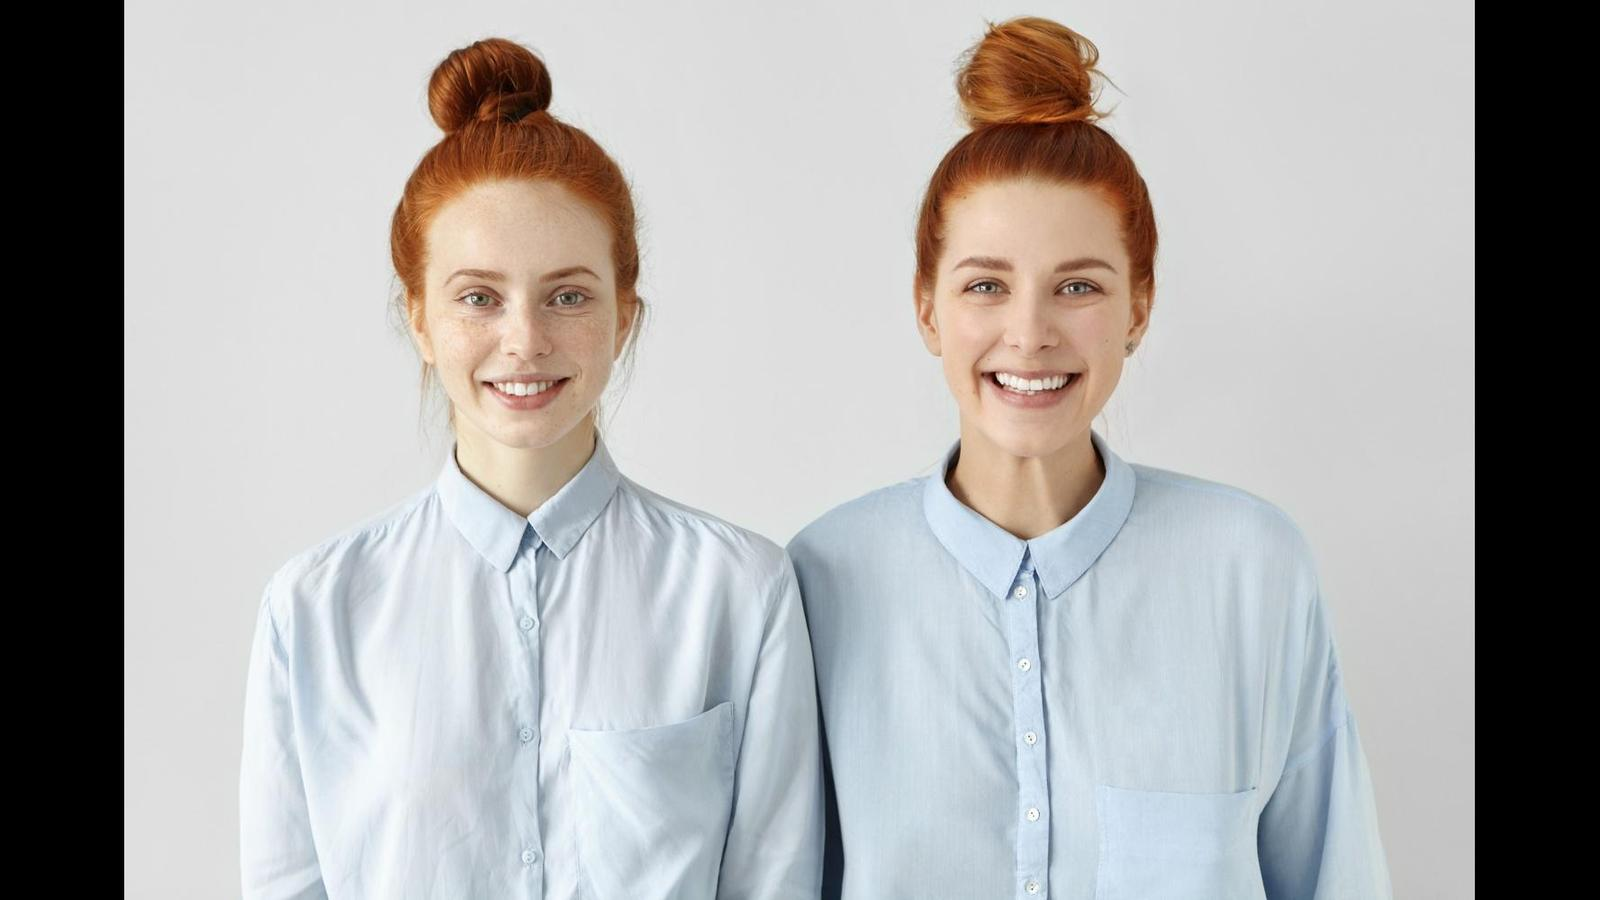

In [7]:
image = Image.open(f"gibi.jpg")
image

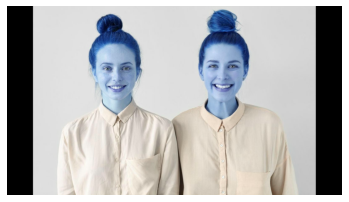

In [9]:
image_padding_aspect_ratio("gibi.jpg", padding_color = (0,0,0), aspect_ratio_width = 16, aspect_ratio_height = 9)

#### Copy Move And Delete

In [26]:
output_file = glob.glob(f"Visual_Genome_{file_ext}_Word_Lemma_Coordinate_Search_Result.csv")
output_file

['Visual_Genome_1000_Word_Lemma_Coordinate_Search_Result.csv']

In [27]:
for l in output_file:
    source = l # source directory
    destination = path
    shutil.copy2(source, destination)

In [28]:
for j in output_file:
    try:
        os.remove(j)
    except:
        pass